In [1]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input

seed = 2023
np.random.seed(seed)  

# Useful Functions

In [2]:
def display_img(image, title=''):
    plt.title(title)
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.axis('off')
    plt.show()

def plot_history(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('Accuracy')
    plt.plot(xvals, np.array(history.history['accuracy']),'g-', 
             label='Train accuracy')
    plt.plot(xvals, np.array(history.history['val_accuracy']),'r-',
             label = 'Validation accuracy')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()

# Load + Pre-Process Data

In [3]:
def readAndResizeImages(data_dir, with_labels=True):
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), 128, 128, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), 128, 128, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image = tf.image.resize(image, [128, 128])
        X[i] = image
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.resize(mask, [128, 128], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [4]:
X_train, Y_train, imageIDs_train = readAndResizeImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndResizeImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndResizeImages("./data/stage2_test_final", with_labels=False)

2023-04-29 13:02:31.593762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30999 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0


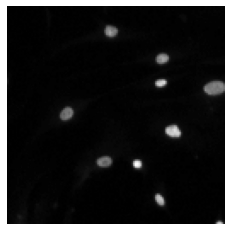

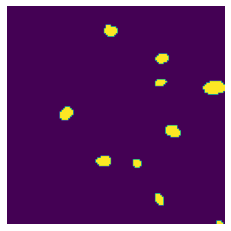

In [5]:
display_img(X_train[1])
display_img(Y_train[1])

# Train Model

In [6]:
# The convolation block 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x


# The encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    
    return x, p


# The decoder block
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [7]:
def create_model(input_shape, LR):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=LR), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [8]:
batch_size = 32
batches_per_epoch = int(len(X_train)/batch_size) 
epochs = 50
LR = 0.0001
stopping_patience = 10
stopping_delta = 0.001

model = create_model((128, 128, 3), LR)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                     patience=stopping_patience, 
                                                     min_delta=stopping_delta,
                                                     verbose = 1,
                                                     restore_best_weights=True)

results = model.fit(X_train, Y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,  
                    validation_data=(X_val, Y_val),
                    callbacks = [stopping_callback],
                    shuffle=True)

Epoch 1/50


2023-04-29 13:04:04.480271: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


21/21 [==============================] - 30s 243ms/step - loss: 0.0000e+00 - accuracy: 0.8696 - val_loss: 0.0000e+00 - val_accuracy: 0.8044
Epoch 2/50
21/21 [==============================] - 3s 135ms/step - loss: 0.0000e+00 - accuracy: 0.9168 - val_loss: 0.0000e+00 - val_accuracy: 0.7490
Epoch 3/50
21/21 [==============================] - 3s 139ms/step - loss: 0.0000e+00 - accuracy: 0.9443 - val_loss: 0.0000e+00 - val_accuracy: 0.8409
Epoch 4/50
21/21 [==============================] - 3s 139ms/step - loss: 0.0000e+00 - accuracy: 0.9532 - val_loss: 0.0000e+00 - val_accuracy: 0.8516
Epoch 5/50
21/21 [==============================] - 3s 139ms/step - loss: 0.0000e+00 - accuracy: 0.9575 - val_loss: 0.0000e+00 - val_accuracy: 0.8713
Epoch 6/50
21/21 [==============================] - 3s 139ms/step - loss: 0.0000e+00 - accuracy: 0.9608 - val_loss: 0.0000e+00 - val_accuracy: 0.8767
Epoch 7/50
21/21 [==============================] - 3s 140ms/step - loss: 0.0000e+00 - accuracy: 0.9623 - val_

Training set Accuracy: 0.9669
Training set Loss:0.000000

Validation set Accuracy: 0.9345
Validation set Loss:0.000000



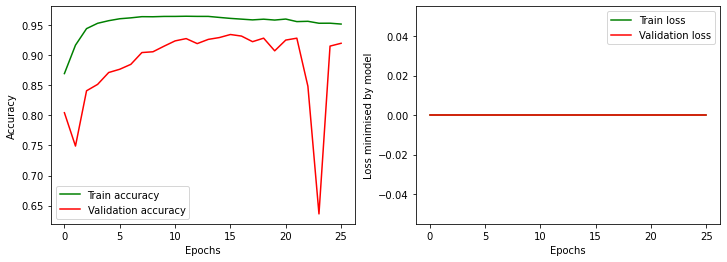

In [10]:
[train_loss, train_accuracy] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(results)

## Testing

In [11]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

95/95 [==============================] - 4s 42ms/step


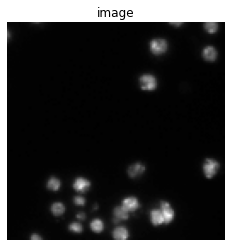

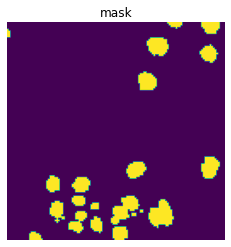

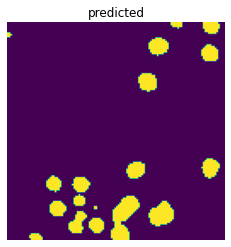

In [12]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

ix = random.randint(0, len(preds_val_t))
ix = 78
display_img(X_train[ix], title="image")
display_img(Y_train[ix], title="mask")
display_img(preds_train_t[ix], title="predicted")

In [13]:
ix

78

## Export Predicted masks to CSV

In [15]:
testset_predictions = (preds_test > 0.5).astype(np.uint8)

In [56]:
template_csv = "./data/stage2_sample_submission_final.csv"
image_dir = "./data/stage2_test_final"
output_csv = "submission_test.csv"

show_no_nuclei_images = False

print(f"Saving {testset_predictions.shape[0]} predictions")
with open(output_csv, 'w', newline='') as output_csvfile:
    writer = csv.DictWriter(output_csvfile, fieldnames=["ImageId", "EncodedPixels"])
    writer.writeheader()
    total_nucleus_count = 0
    
    progress_indices = np.linspace(0, testset_predictions.shape[0], 21, dtype=int)
    
    with open(template_csv, newline='') as template_csvfile:
        for i, (imgID, _) in enumerate(csv.reader(template_csvfile, delimiter=',')):
            if i == 0: # Skip row with labels
                continue

            # Get Prediction For ImgID
            prediction = testset_predictions[imageIDs_test.index(imgID)]

            # Scale Predicted Mask Back To Original Image Size
            original_image_size = Image.open(f"{image_dir}/{imgID}/images/{os.listdir(f'{image_dir}/{imgID}/images')[0]}").size
            predicted_mask = tf.keras.utils.img_to_array(
                tf.image.resize(prediction, original_image_size, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            )[:, :, 0]
            
            predicted_mask_T = predicted_mask.transpose()
            
            # Label each nucleus in mask
            (labeled_mask, nucleus_amount) = skimage.measure.label(predicted_mask_T, connectivity=2, background=0, return_num=True)
            total_nucleus_count += nucleus_amount
            if nucleus_amount == 0 and show_no_nuclei_images:
                print(f"No nuclei found for image {imgID}")
                try:
                    display_img(Image.open(f"{image_dir}/{imgID}/images/{os.listdir(f'{image_dir}/{imgID}/images')[0]}"))
                except:
                    print(f"Error while displaying image {imgID}")
            
            # Calculate RLE
            RLE = [[] for _ in range(nucleus_amount)]
            curr_pixel = 1
            run_length = 0
            run_label = 0
            
            for i_c, c in enumerate(labeled_mask):
                for i_r, x in enumerate(c):
                    if x:
                        if run_length == 0 or run_label != x:
                            if run_length > 0:
                                RLE[run_label-1].append(run_length)
                                run_length = 0
                            RLE[x-1].append(i_c * labeled_mask.shape[1] + i_r + 1)
                            run_label = x
                        run_length += 1
                    elif run_length > 0:
                        RLE[run_label-1].append(run_length)
                        run_length = 0
                        run_label = 0
            if run_length > 0:
                RLE[run_label-1].append(run_length)
            
            # Write To output file
            for nucleus_RLE in RLE:
                writer.writerow({"ImageId": imgID, "EncodedPixels": ' '.join(map(str, nucleus_RLE))})
            
            if nucleus_amount == 0: # default entry
                writer.writerow({"ImageId": imgID, "EncodedPixels": ''})
            
            # Show sign of progress
            if i in progress_indices:
                print(f"{np.where(progress_indices == i)[0][0] * 5}%")
    
    print()
    print(f"Found {total_nucleus_count} nuclei in {testset_predictions.shape[0]} images")

Saving 3019 predictions
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%

Found 72769 nuclei in 3019 images
